## Sandwich_profile_metrics
This notebook explores processing profiles.

### Processing steps
* Read in the 3D array
* Smooth? Not yet

TODO:
* Correct DEMs for snow, dune grass
* Examine sensitivity of smoothing

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from scipy import interpolate, signal, stats
from astropy.convolution import Gaussian1DKernel, Box1DKernel, Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve as astropy_convolve
%matplotlib inline

# define functions in this .py file
%run -i pmetrics

In [13]:
# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"])

In [14]:
da = xr.open_dataarray('Sandwich_1m_DEM_v2_nf.nc')
(nmaps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',nmaps,ysize,xsize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Alongshore'], da.coords['Cross-shore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))

# coordinate vectors
x, y = da.coords['Alongshore'], da.coords['Cross-shore'].values

# convert dataArry to np array, and change missing values to NaNs
zmap = np.array( da.values.copy() )
zmap[zmap <= -1.]=np.NaN

Shape of stacked elevation array:  14 280 1300
Shape of X and Y (280, 1300) (280, 1300)


pmetrics.py:14: RuntimeWarning: invalid value encountered in less_equal
  TODO: Check varying dx and dy. I think that is as simple as multipying the


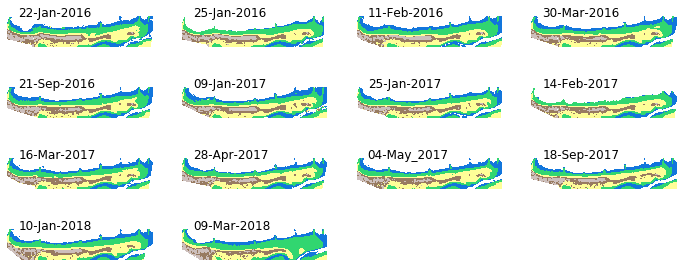

In [15]:
# declare a plot size
clevels = [-2,0,2,4,6,8]
fig  = plt.figure(figsize=(12,5))
for i in range(nmaps):
# small plots of elevation
    ax=fig.add_subplot(4,4,i+1)
    plt.axis('off')
    plt.contourf(X,Y,np.squeeze(zmap[i,:,:]),clevels,cmap=plt.cm.terrain)
    plt.text(100,270,titles[i],fontsize=12)
    ax.set_aspect(1.);

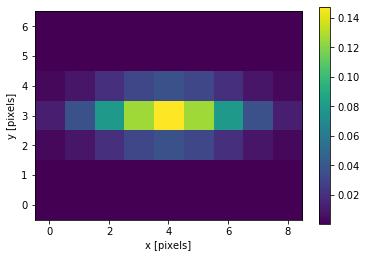

Shape:  (14, 280, 1300)
mean [2.04870903 2.32739823 1.85736965 1.92956528 1.94537173 1.94362893
 2.0131902  2.31411763 1.94125257 2.12761113 2.01857004 2.06917816
 2.00044882 1.73286712]
mad [2.20589396 2.38807438 2.02913061 2.09437427 2.11761094 2.13279222
 2.13809547 2.39001816 2.10857031 2.25376021 2.17815082 2.23637172
 2.15343911 1.8645512 ]
min [-0.95188639 -0.8925197  -0.95884667 -0.95754973 -0.96627186 -0.95110779
 -0.93386362 -0.96812319 -0.95770017 -0.9618544  -0.96043602 -0.94501426
 -0.96915697 -0.94056455]
max [13.26421881 13.45850527 13.86085186 13.50321066 13.37182042 13.6576369
 13.78295229 13.42330886 13.36917813 13.54830516 13.38824151 13.5521332
 14.3389633  14.97967874]
rms [2.85175743 2.99942863 2.71387965 2.71880726 2.76362107 2.76060018
 2.74247958 2.92158927 2.69785065 2.86758027 2.77776054 2.85668467
 2.79057554 2.5682784 ]
nans [146708, 176024, 141102, 149769, 149739, 151844, 168179, 187409, 163292, 171490, 154737, 162762, 154862, 147890]
size [364000, 364000,

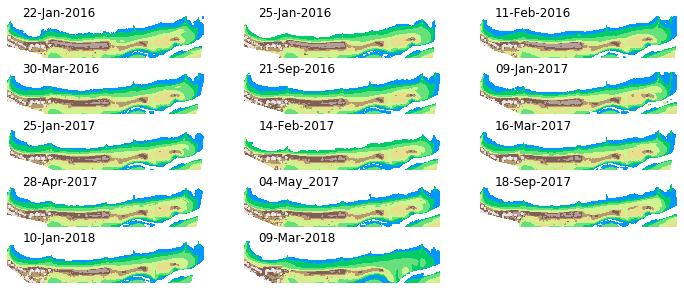

In [17]:
# smooth the maps using the scipy filter, which will enlarge regions of NaNs. But use anisotropic, sharp Gaussian kernal.
smooth_maps=True
if(smooth_maps):
    gaussian_2D_kernel = Gaussian2DKernel(1.8, .6, theta=0., x_size=9, y_size=7)
    plt.imshow(gaussian_2D_kernel, interpolation='none', origin='lower')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.colorbar()
    plt.show()
    print(gaussian_2D_kernel)

    smap=np.nan*np.ones_like(zmap)
    for imap in range(nmaps):
        smap[imap,:,:] = scipy_convolve(np.squeeze(zmap[imap,:,:]), gaussian_2D_kernel, mode='same', method='direct')

    map_stats3d(smap)

    # plot the maps
    clevels = [-2,-1,0,1,2,3,4,5,6,7,8]

    fig  = plt.figure(figsize=(12,5))
    for i in range(nmaps):
    # small plots of elevation
        ax=fig.add_subplot(5,3,i+1)
        plt.axis('off')
        plt.contourf(X,Y,np.squeeze(smap[i,:,:]),clevels,cmap=plt.cm.terrain)
        plt.text(100,270,titles[i],fontsize=12)
        ax.set_aspect(1.);
else:
    smap = zmap.copy()

In [19]:
if(False):
    # calculate difference maps
    dmap = np.diff(smap,n=1,axis=0)
    print(np.shape(dmap))

    # plot the maps
    dclevels = [-2,-1.5,-1,-0.5,-.25,.25,.5,1.,1.5,2]
    fig  = plt.figure(figsize=(15,7))
    for i in range(nmaps-1):
    # small plots of elevation
        ax=fig.add_subplot(4,4,i+1)
        plt.axis('off')
        plt.contourf(X,Y,np.squeeze(dmap[i,:,:]),dclevels,cmap=plt.cm.seismic_r)
        plt.text(100,270,titles[i+1]+' minus '+titles[i],fontsize=9)
        ax.set_aspect(1.);

In [20]:
def shoreline(x,z,zt,order='last',npts=5):
    """
    Find the x value for elevation zt
    """
    md = np.nanmin(np.abs(z-zt))
    print(md)
    dd = np.where(np.abs(z-zt)<=md)
    print(len(dd))
    if(len(dd)>1):
        if(order=='last'):
            dd = dd[-1]
        else:
            dd = dd[0]
    print(dd)
    return dd

In [21]:
# Test shoreline with a profile
imap=7
x =da.coords['Cross-shore'].values
z =smap[imap,:,400]
shoreline(x,z,1.43)

0.016720420537738923
1
(array([107], dtype=int64),)


pmetrics.py:7: RuntimeWarning: invalid value encountered in less_equal
  def hmetrics( z, dx=1., dy=1.):


(array([107], dtype=int64),)

pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
pmetrics.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

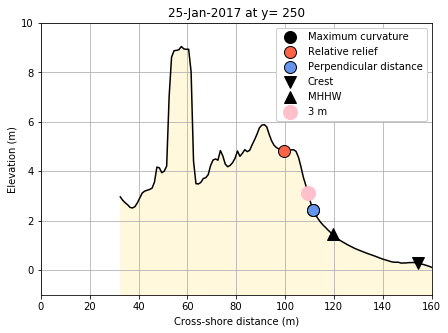

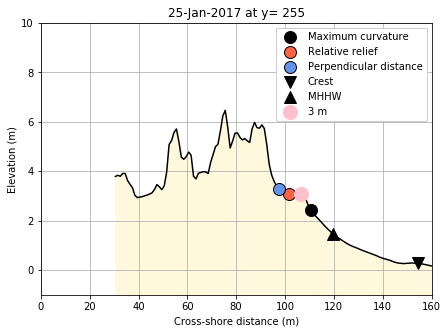

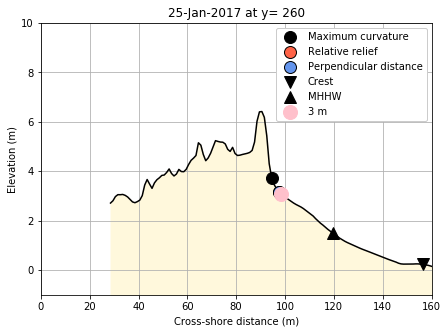

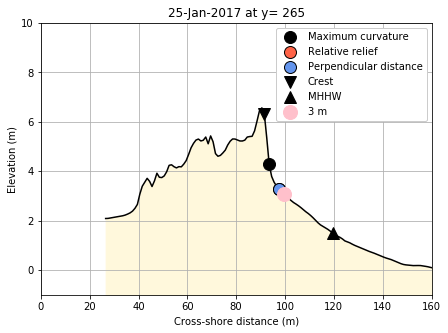

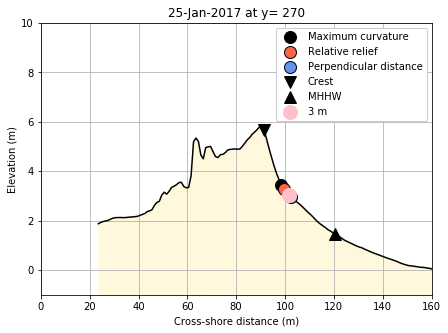

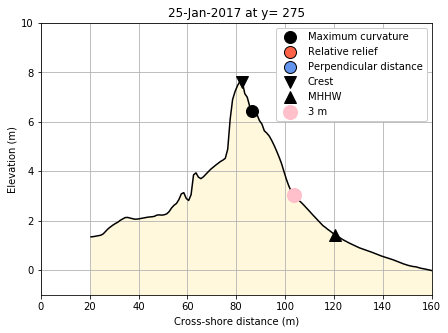

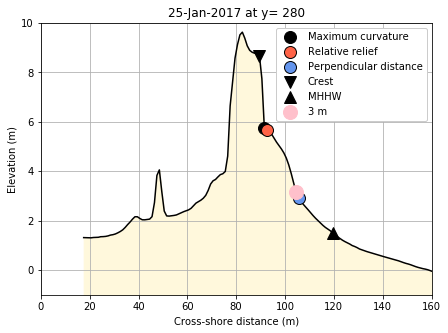

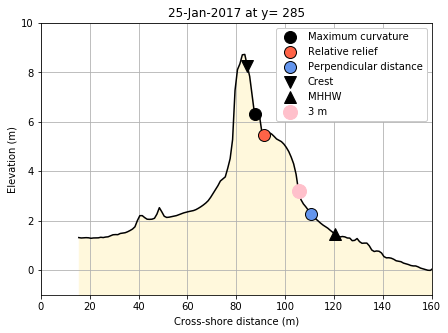

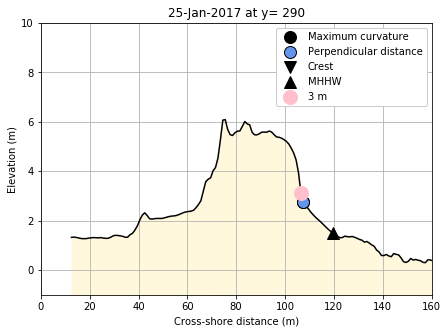

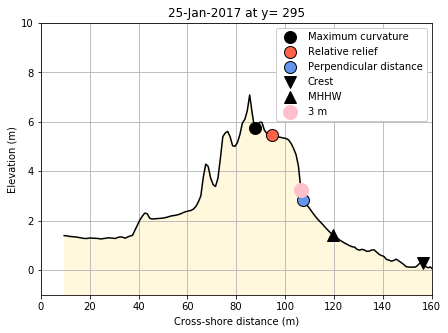

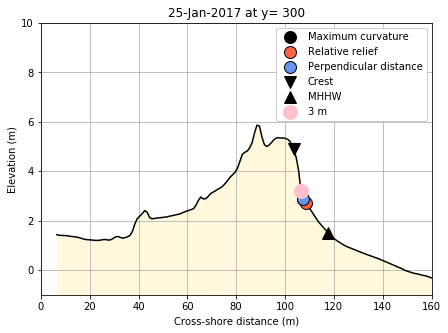

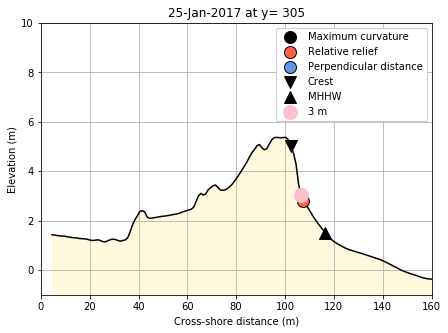

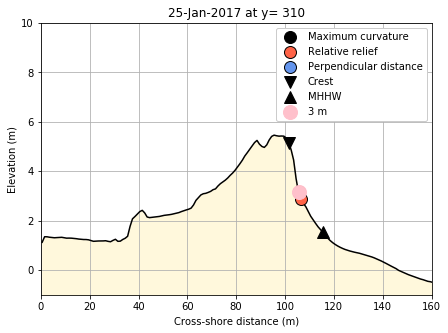

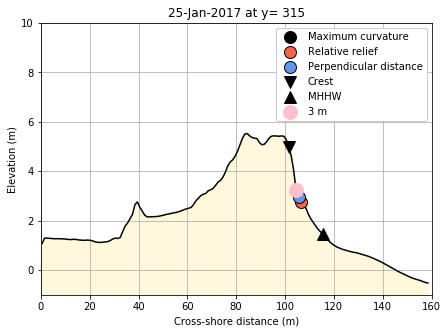

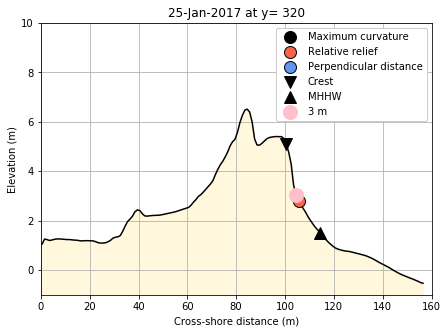

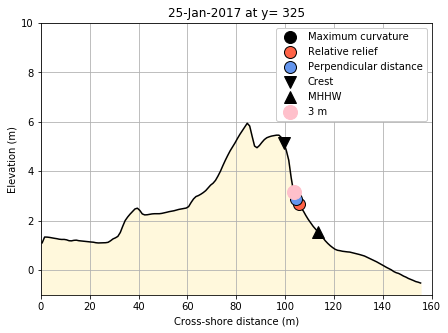

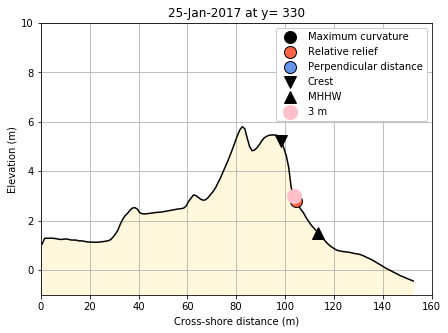

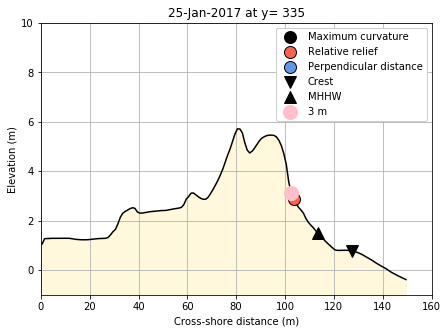

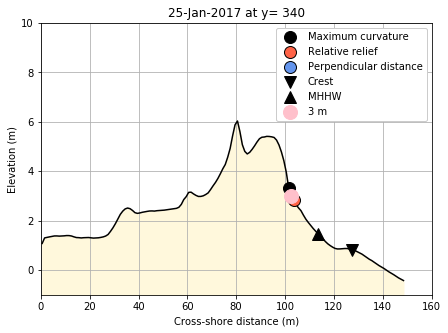

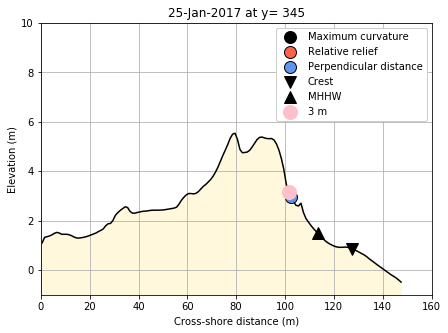

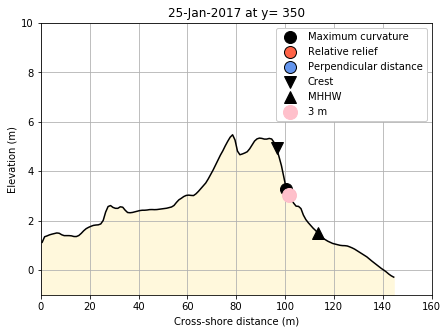

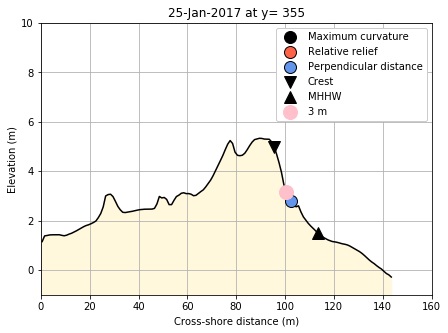

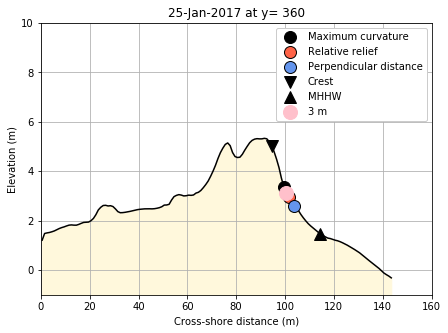

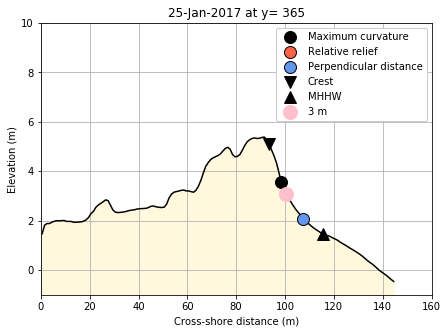

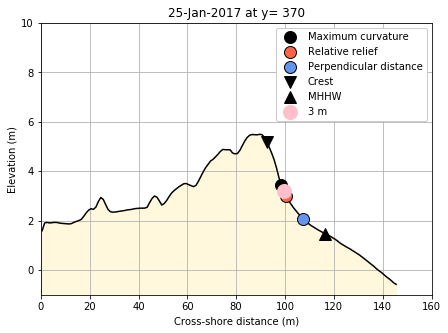

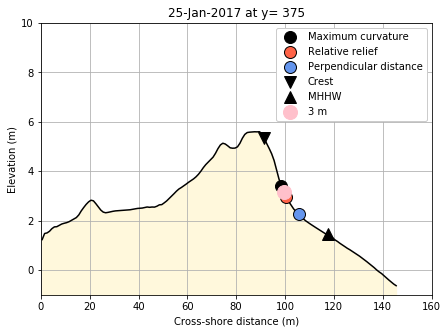

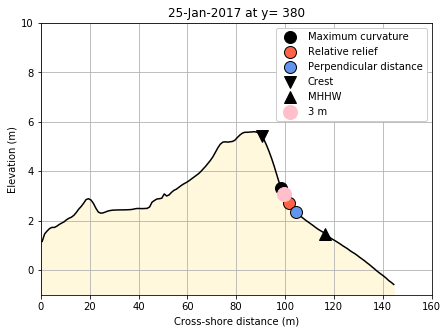

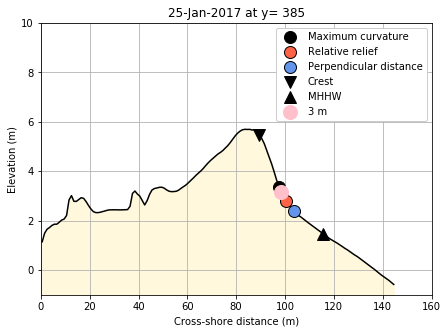

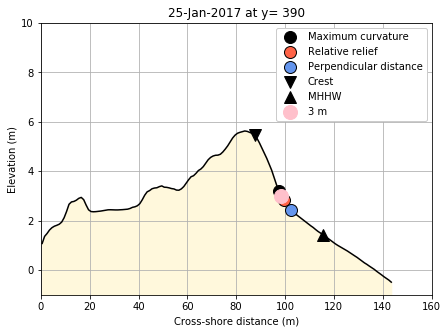

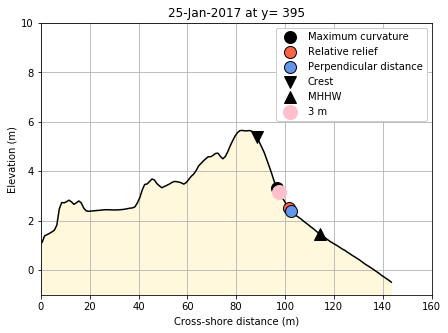

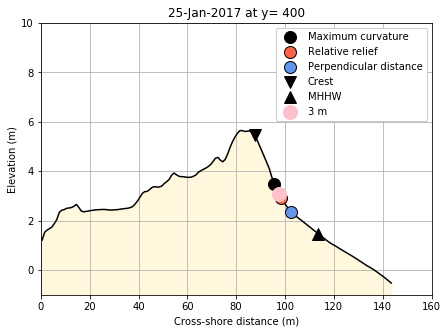

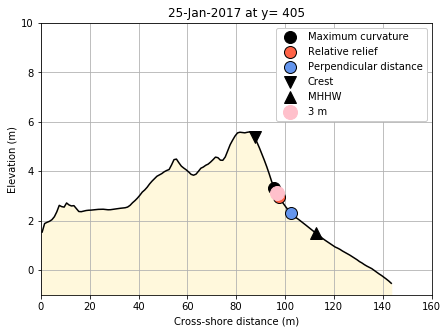

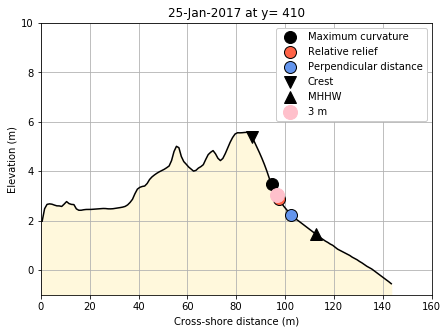

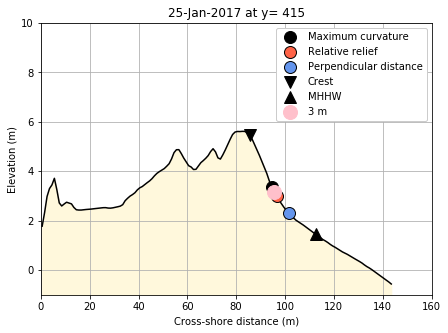

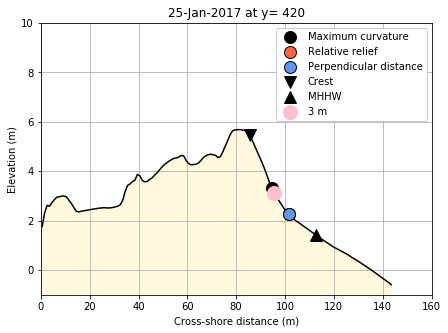

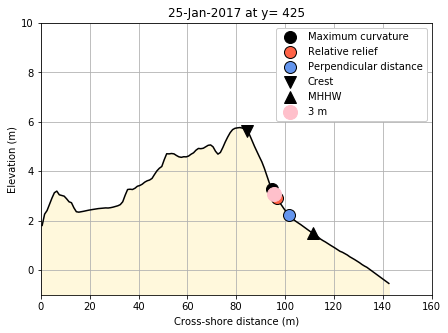

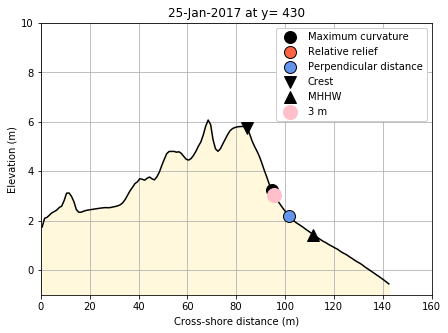

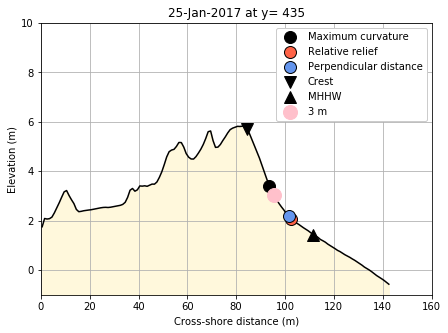

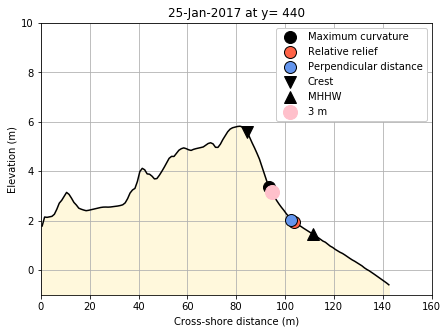

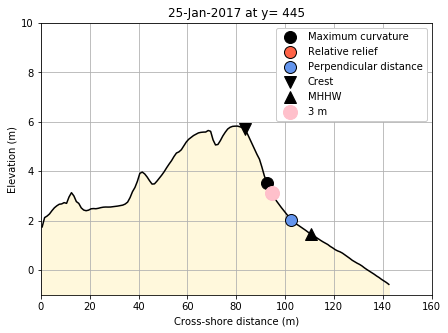

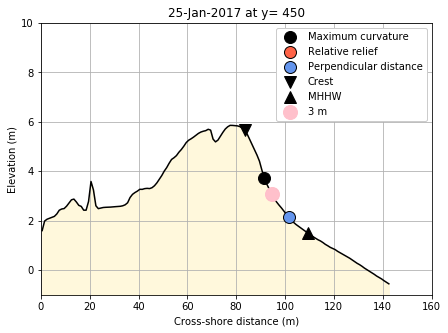

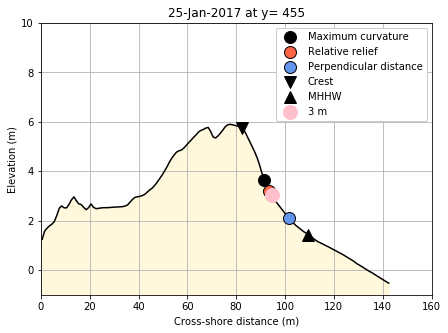

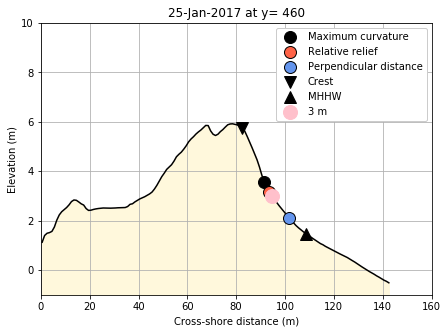

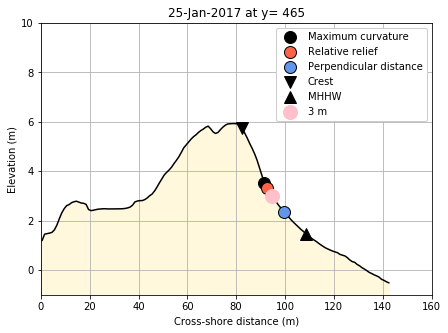

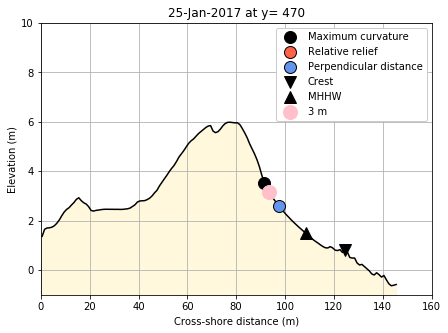

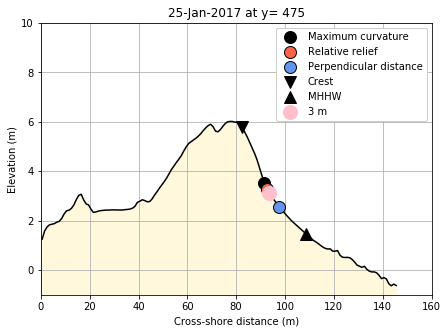

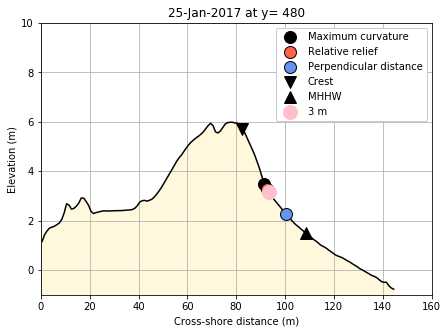

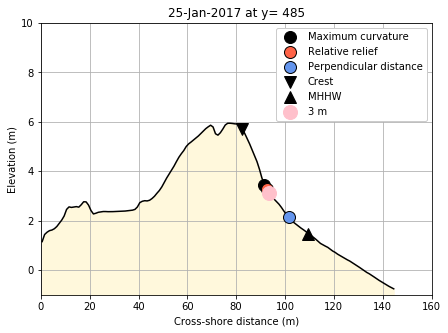

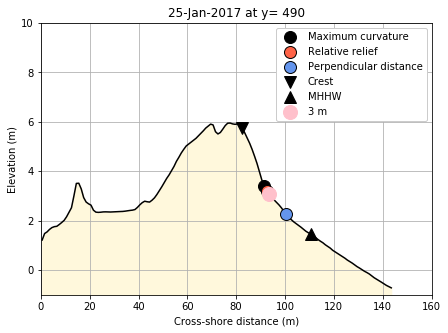

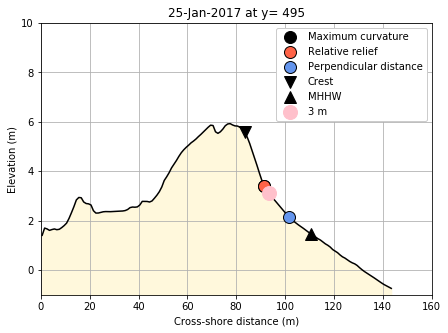

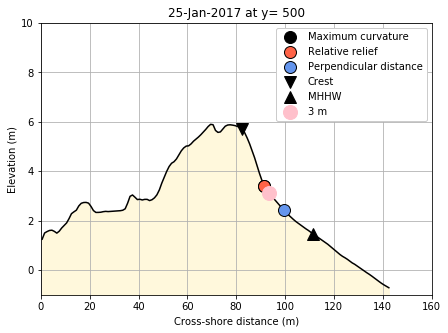

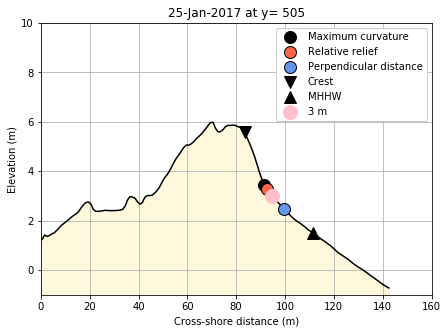

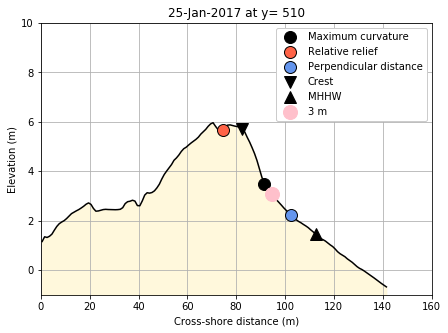

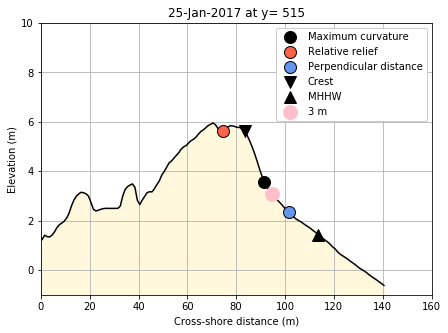

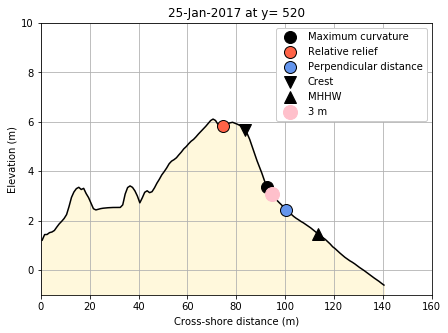

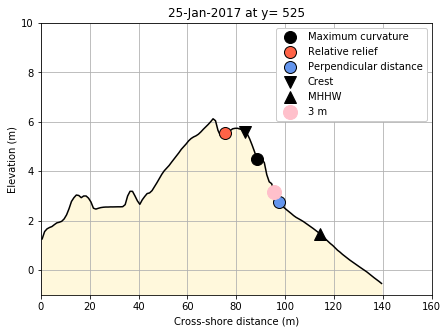

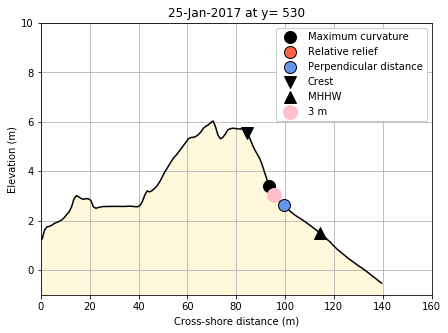

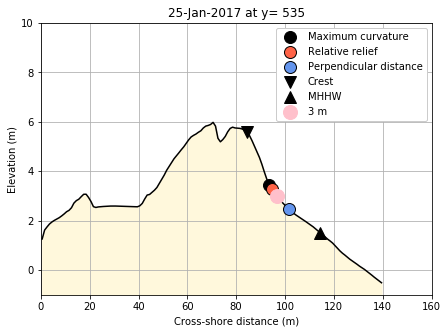

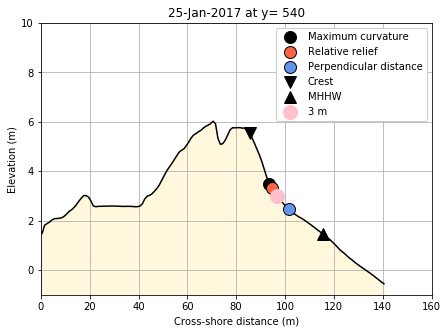

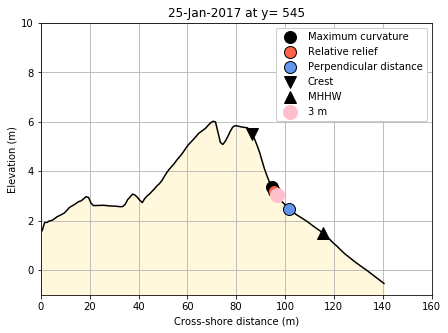

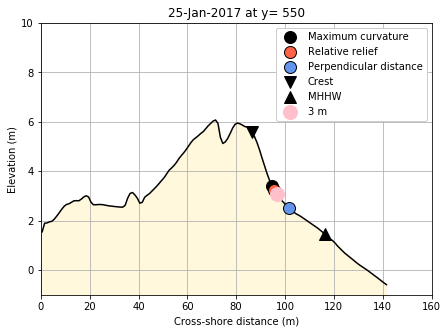

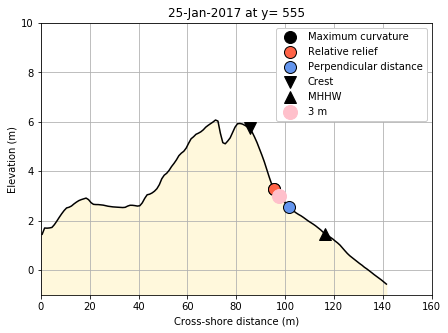

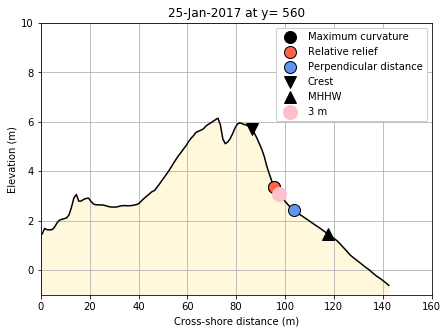

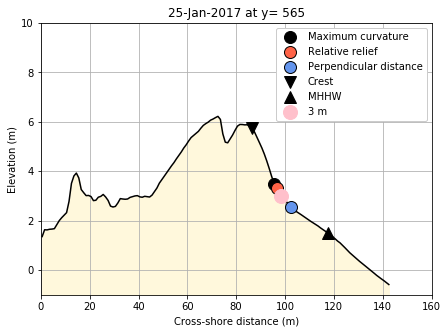

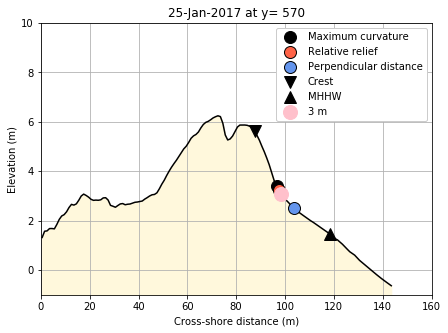

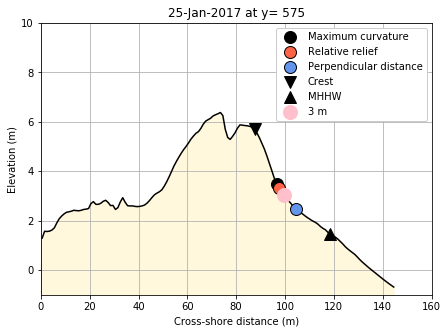

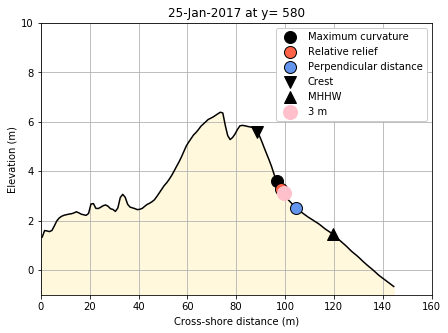

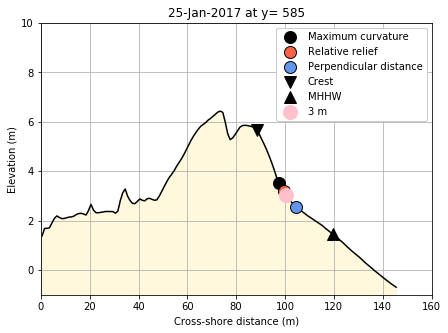

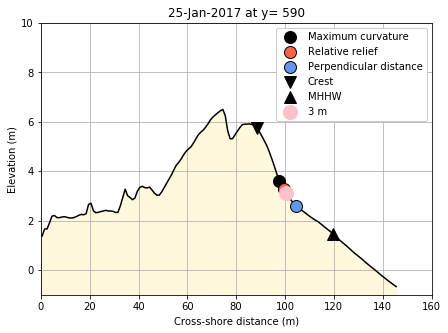

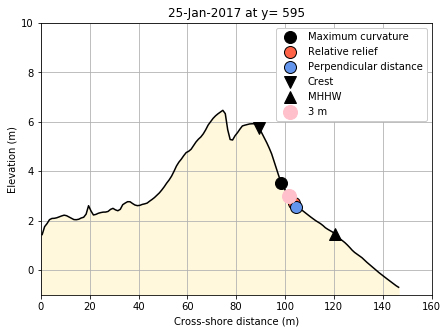

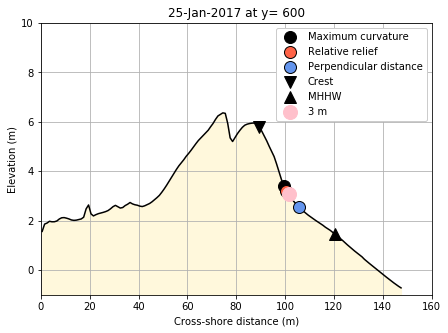

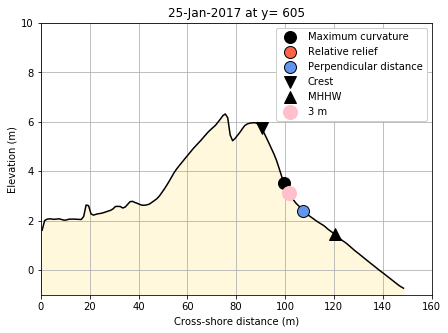

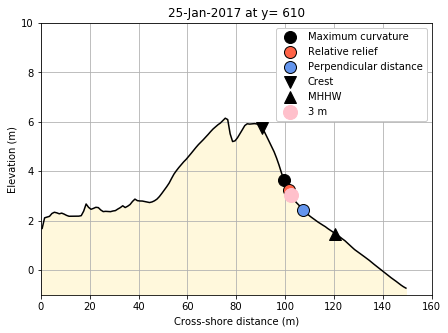

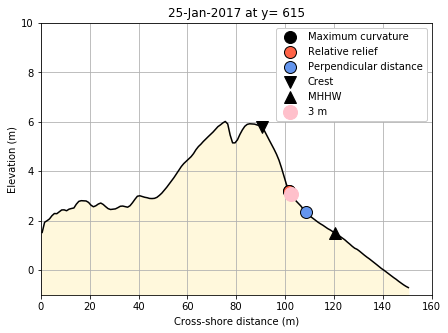

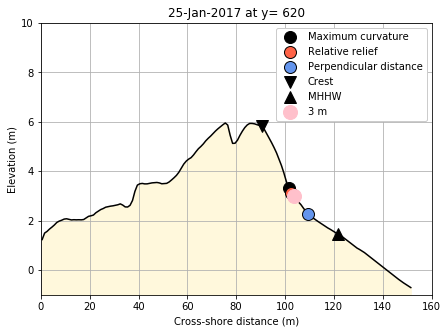

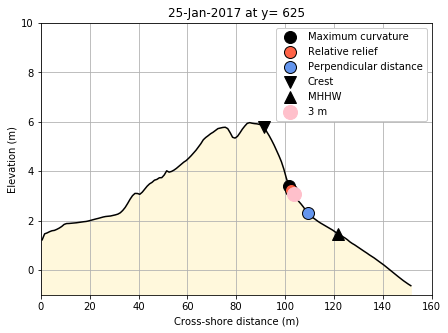

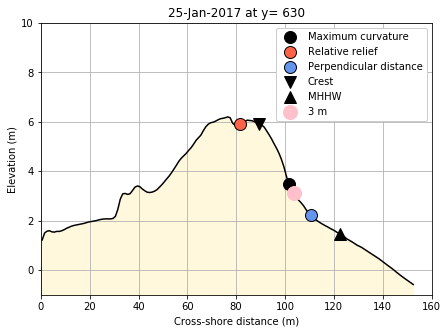

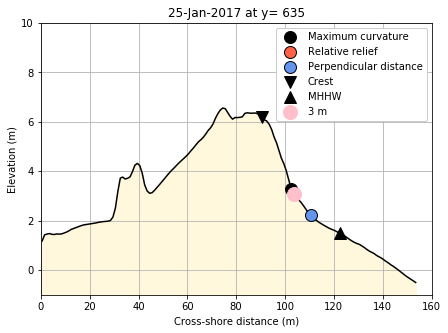

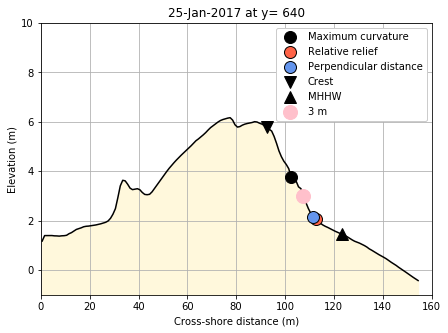

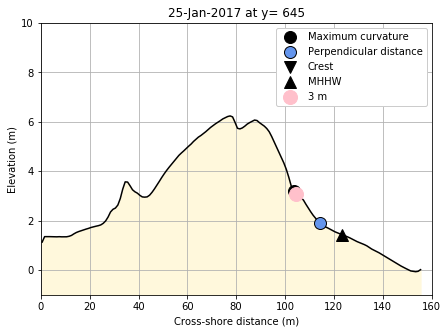

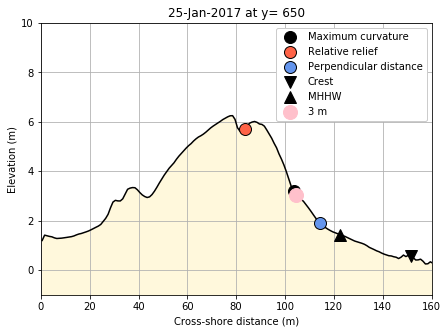

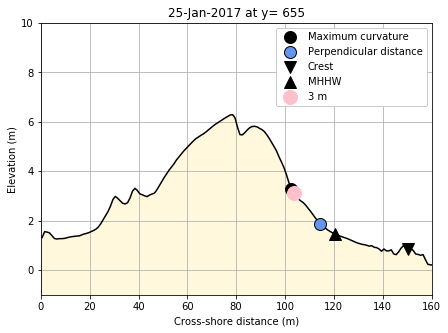

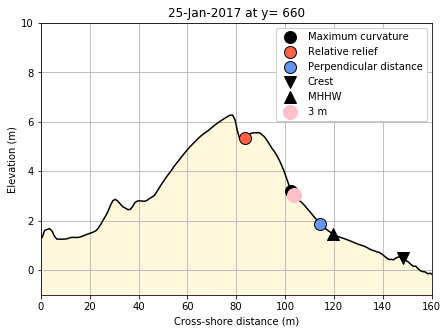

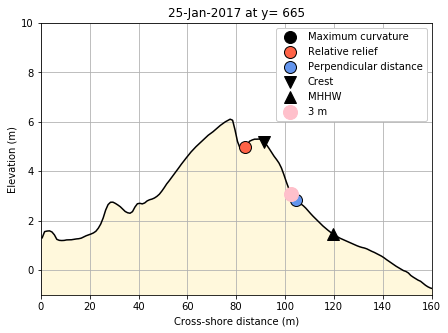

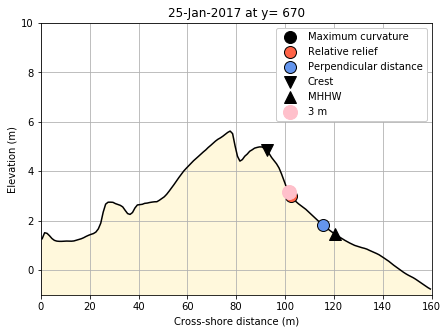

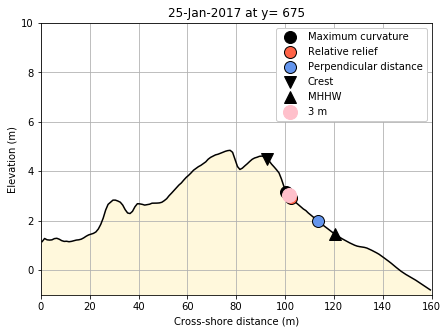

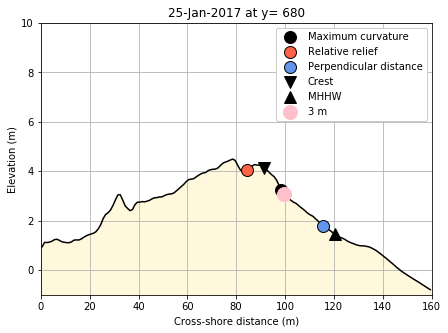

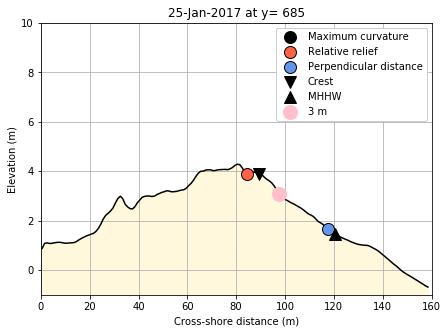

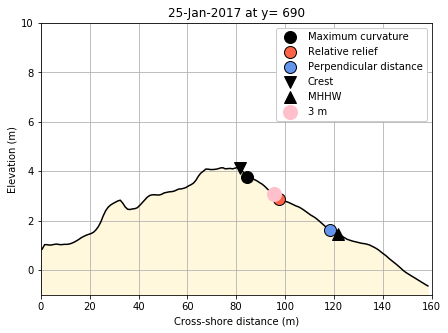

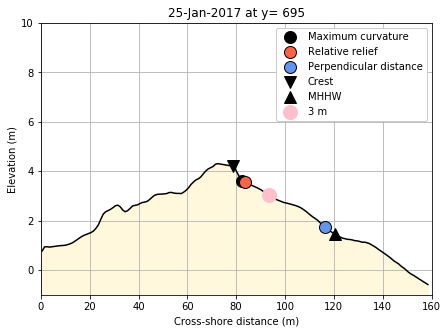

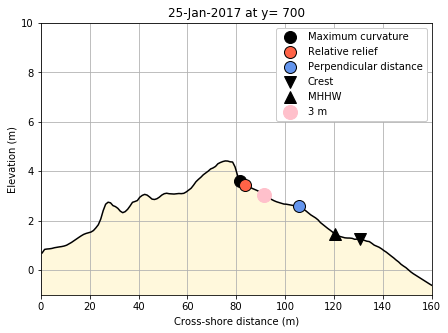

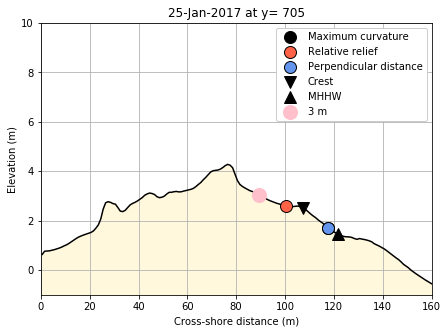

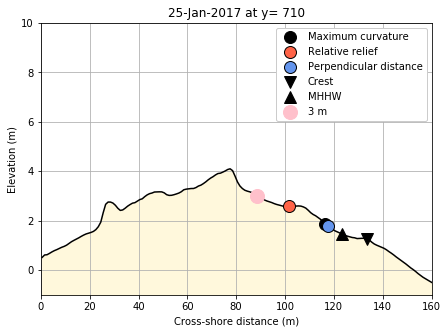

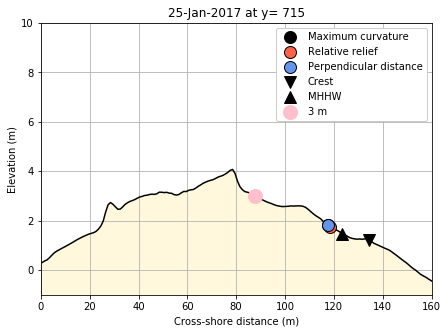

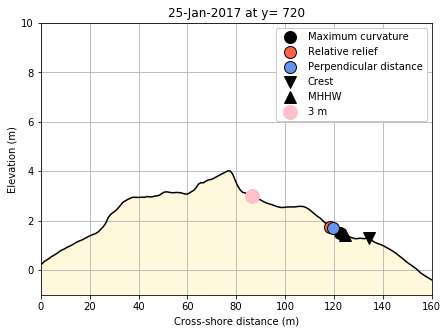

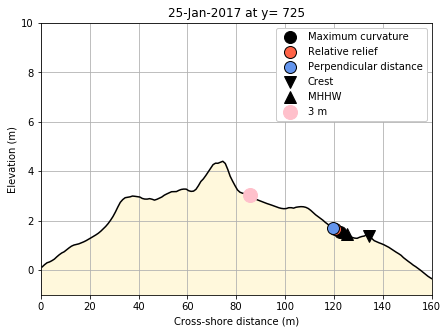

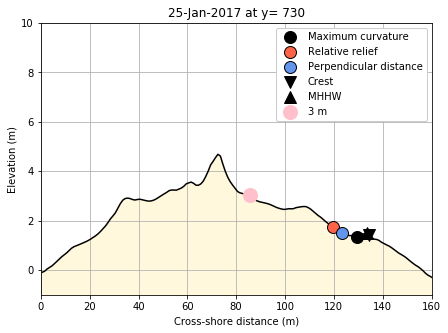

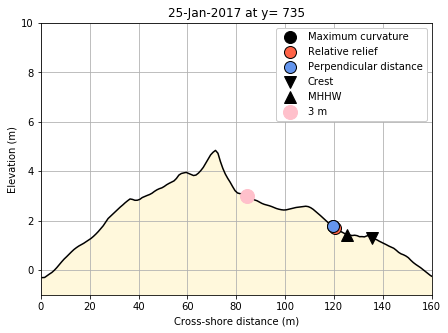

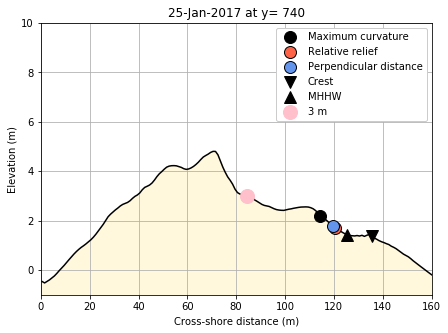

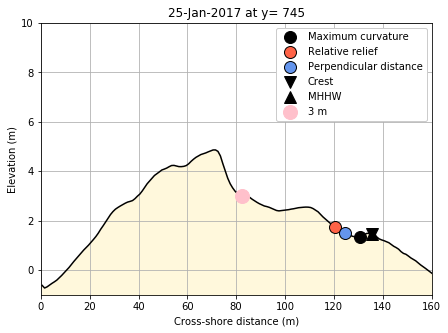

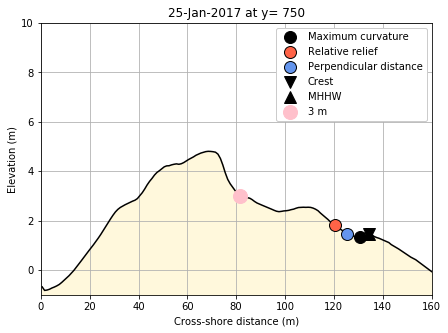

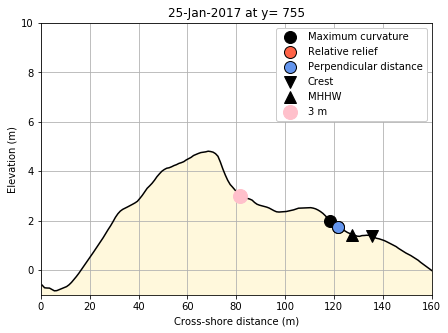

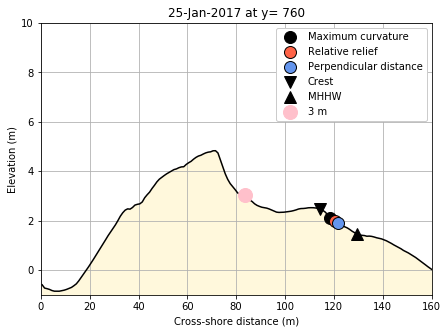

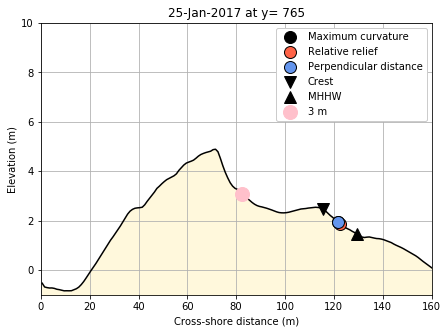

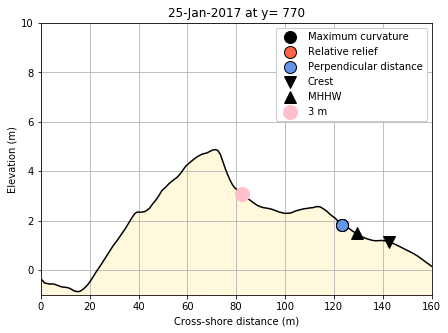

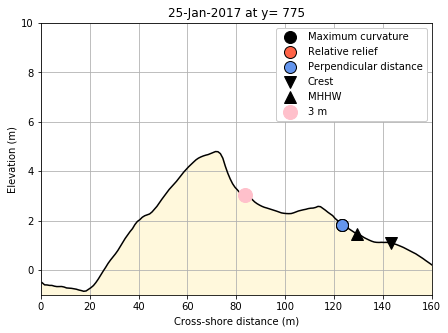

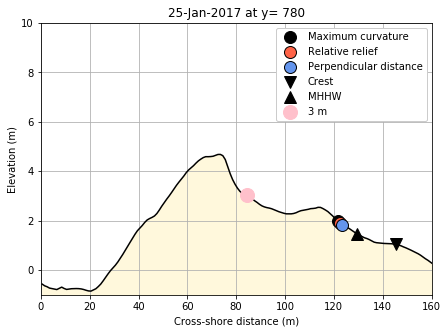

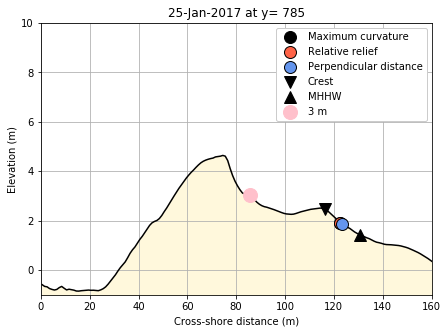

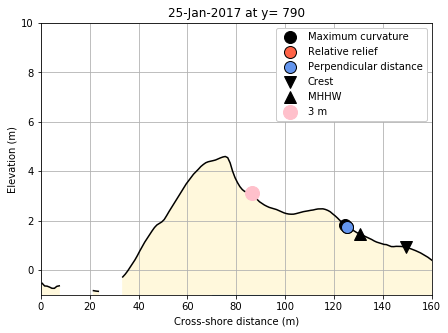

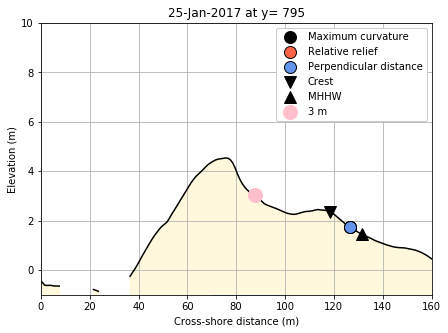

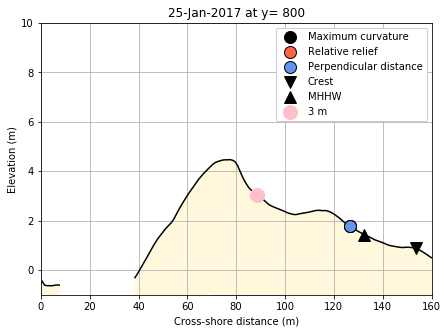

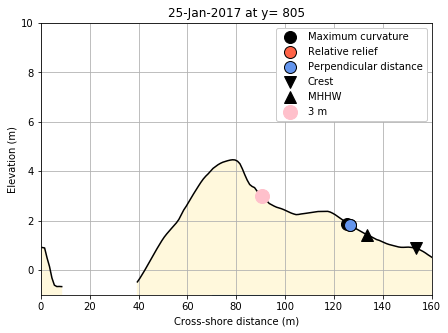

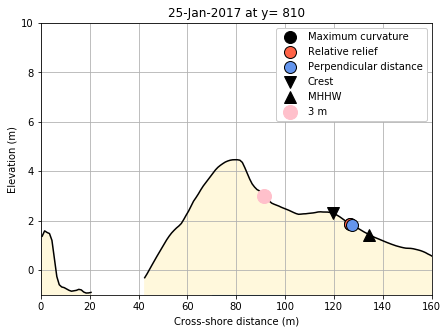

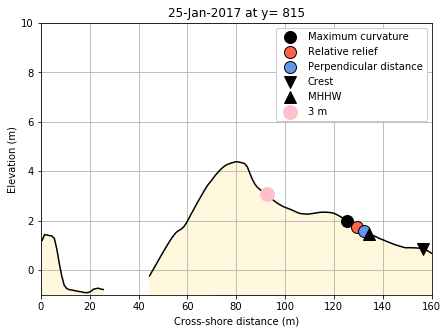

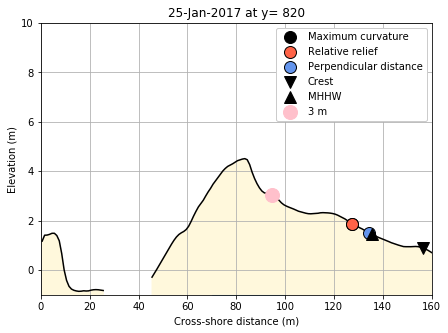

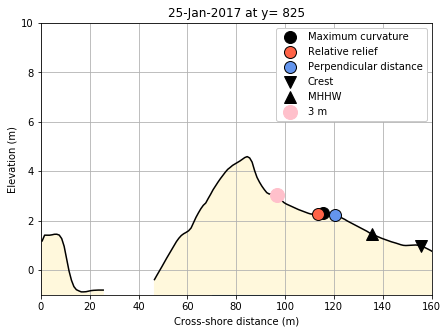

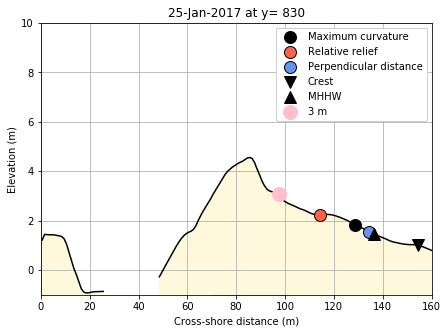

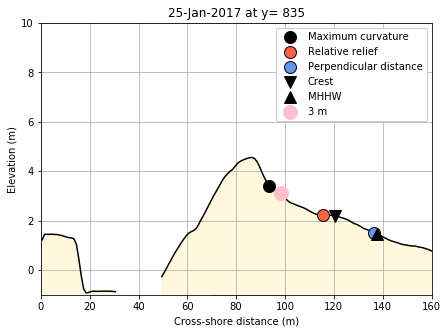

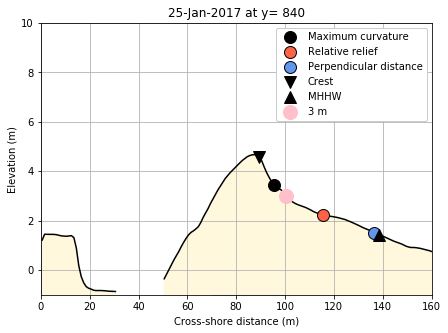

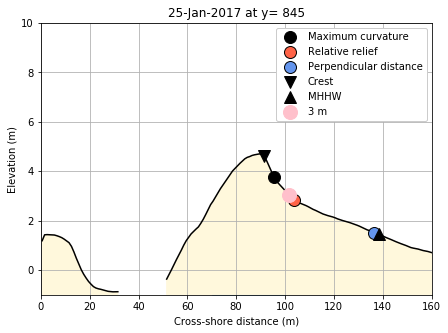

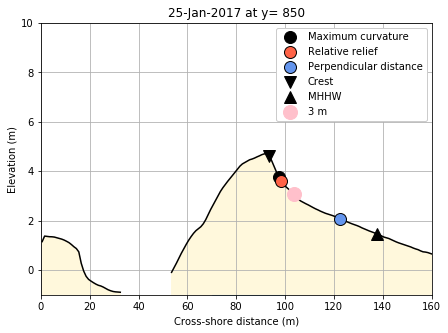

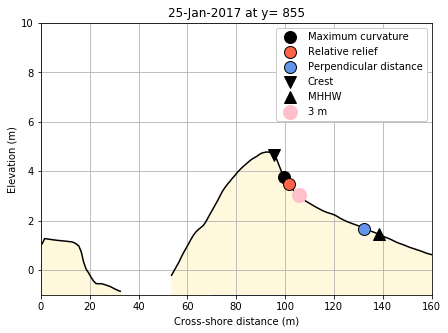

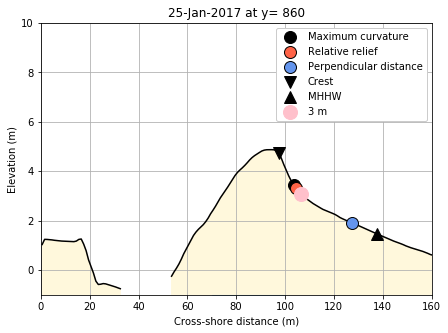

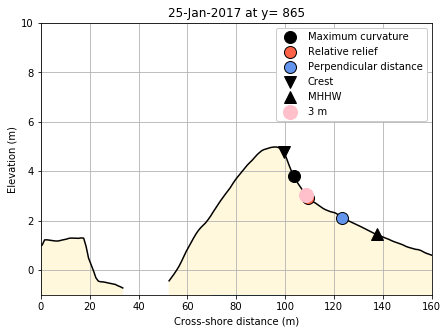

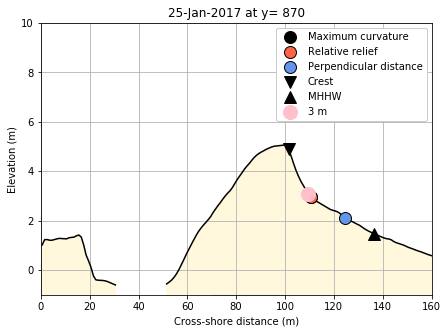

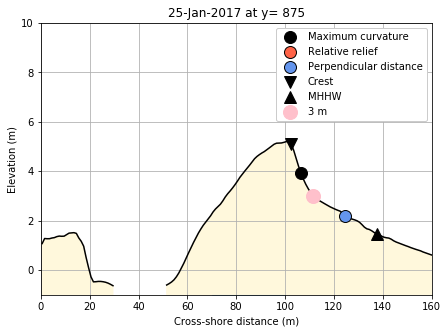

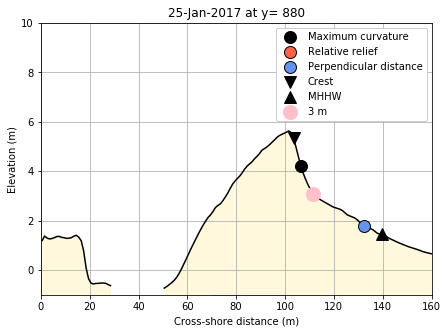

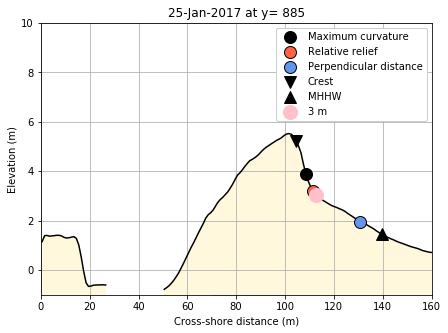

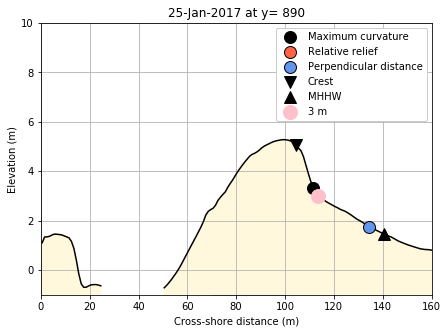

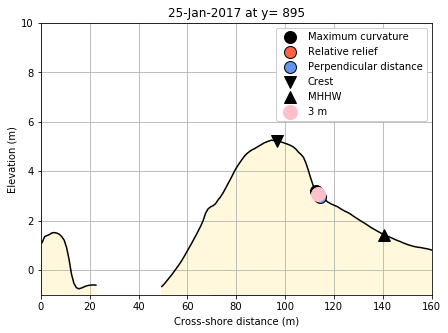

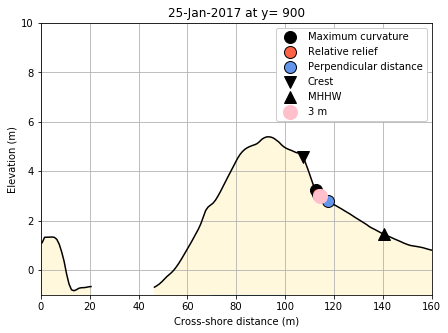

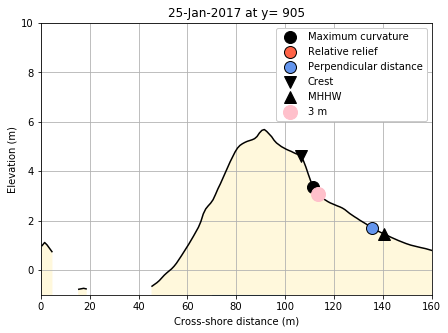

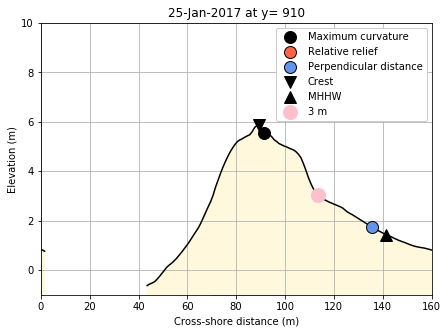

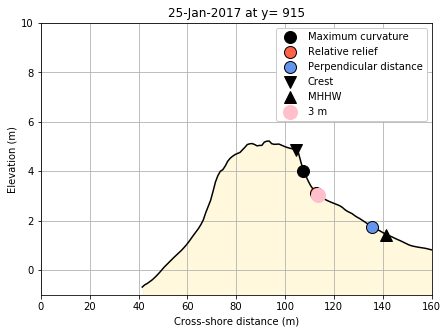

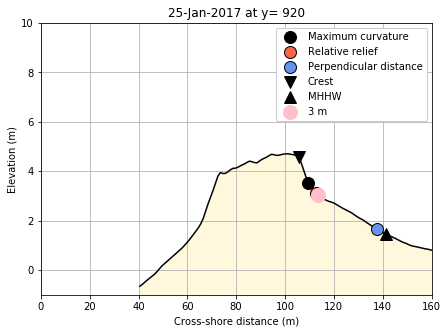

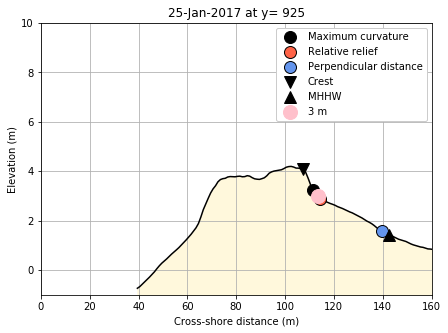

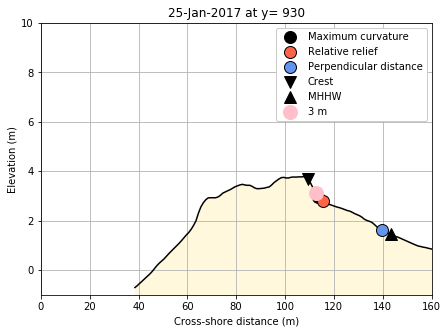

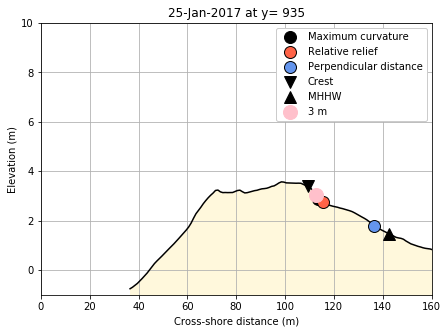

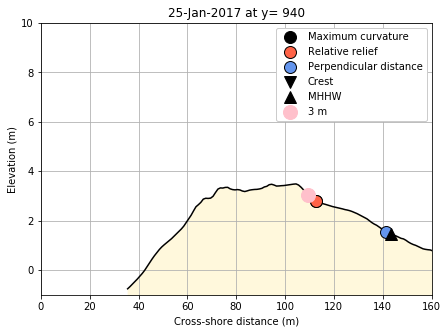

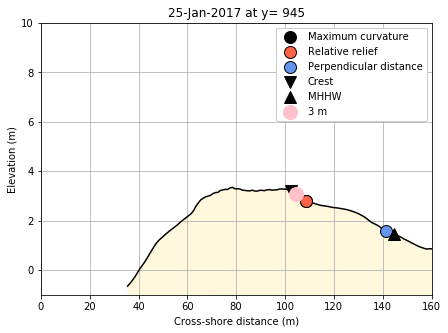

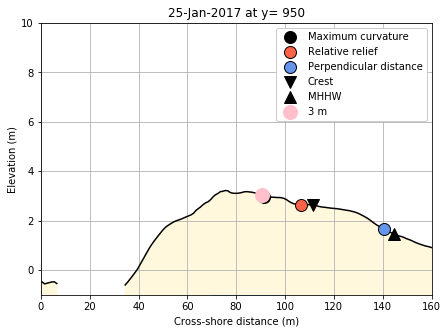

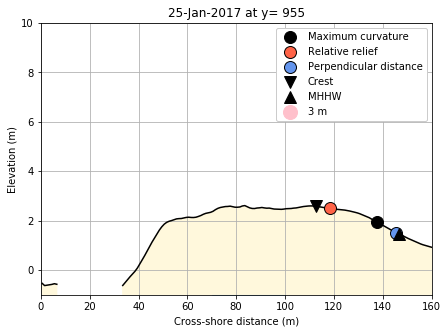

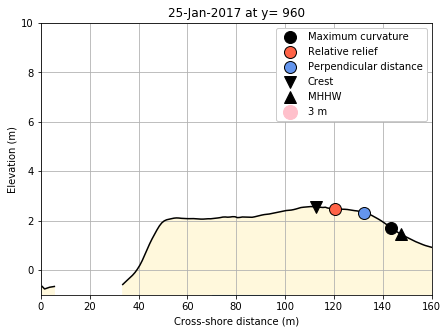

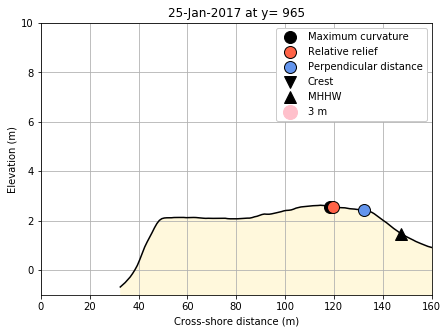

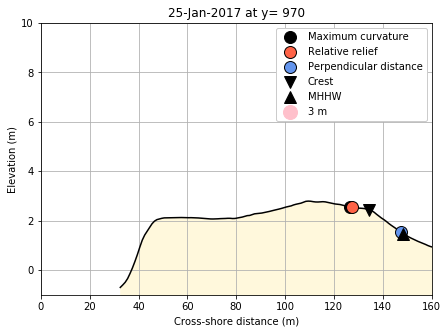

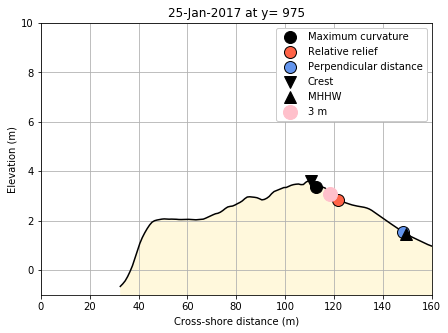

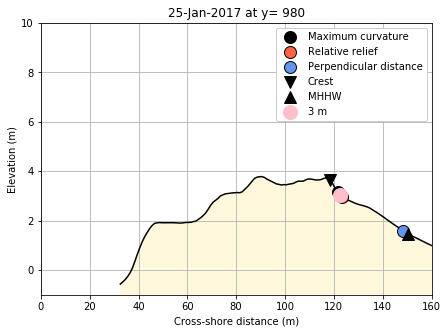

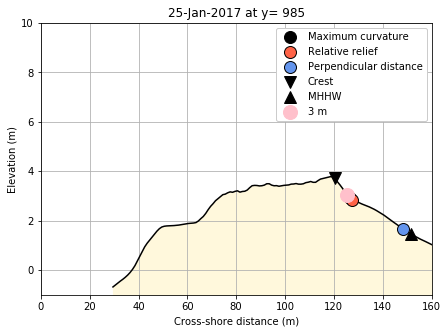

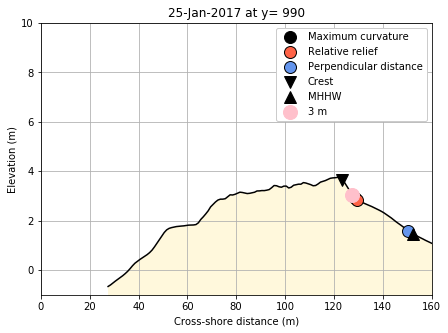

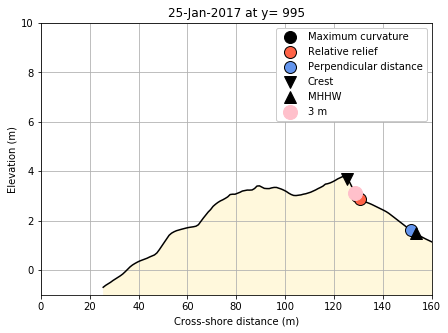

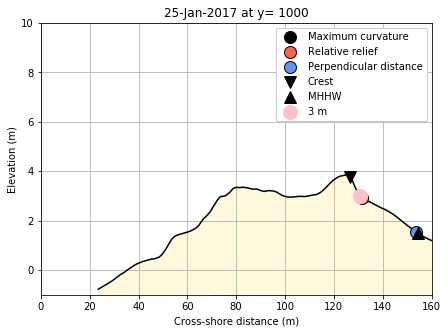

In [23]:
# define the profile metrics function
from pybeach.beach import Profile
MHW = 1.28
MHHW = 1.43
DT = 3.

# spacing of profiles in alongshore direction
dyp = 5
yvals = np.arange(250,1000+dyp, dyp)
pts = np.empty((nmaps,len(yvals),7))

# Loop through the maps
for imap in range(nmaps):
    for i, y in enumerate(yvals):
        x =da.coords['Cross-shore'].values
        z =smap[imap,:,y]
        dx = np.median(np.diff(x))
        p = Profile(x,z)
        try:
            toe_mc = p.predict_dunetoe_mc(dune_crest='rr', water_level=MHHW, window_size=11, threshold=0.97)
        except:
            toe_mc = np.nan
        try:
            toe_rr = p.predict_dunetoe_rr(dune_crest='rr', water_level=MHHW, window_size=41, threshold=0.97, toe_threshold=0.2, verbose=False)
        except:
            toe_rr = np.nan
        try:
            toe_pd = p.predict_dunetoe_pd(dune_crest='rr', water_level=MHHW, window_size=61, threshold=0.4)
        except:
            toe_pd = np.nan
        toes = [toe_mc, toe_rr, toe_pd]

        # Predict dune crest
        crest = p.predict_dunecrest('rr')
        # Predict shoreline
        HW_line = p.predict_shoreline(water_level=MHHW)
        dt = p.predict_shoreline(water_level=DT)     

        pts[imap,i,:]=[y,crest,toe_mc,toe_rr,toe_pd,dt,HW_line]

        if(imap == 6):
            fig, axes = plt.subplots(1, 1, figsize=(7, 5))
            labels = ['Maximum curvature', 'Relative relief', 'Perpendicular distance']
            colors = ['k', 'tomato', 'cornflowerblue']
            # Generate figure
            axes.plot(x, z, '-k')
            axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
            axes.fill_between(x, z, y2=-1, color='cornsilk', alpha=1)
            axes.set_ylim([-2, 10])
            for i, itoe in enumerate(toes):
                if(~np.isnan(itoe)):
                    axes.plot(x[itoe], z[itoe],
                              'o', color=colors[i], ms=12, mec='k', label=labels[i])
            axes.plot(x[crest], z[crest], 'v', color='k', ms=12, mec='k', label='Crest')
            axes.plot(x[HW_line], z[HW_line], '^', color='k', ms=12, mec='k', label='MHHW')
            axes.plot(x[dt],z[dt],'o',color='pink',ms=14,label='3 m')
            ts = '{} at y= {}'.format(titles[imap],y)
            axes.set_title(ts)
            axes.set_xlabel('Cross-shore distance (m)')
            axes.set_xlim([0.,160])
            axes.set_ylabel('Elevation (m)')
            axes.set_ylim([-1.,10])
            axes.grid()
            axes.legend(framealpha=1)

In [24]:
mean_MHHW = np.nanmean(pts[0:13,:,6],axis=0)
std_MHHW = np.nanstd(pts[0:13,:,6],axis=0)
mean_3m = np.nanmean(pts[0:13,:,5],axis=0)
std_3m = np.nanstd(pts[0:13,:,5],axis=0)
np.shape(mean_MHHW)

(151,)

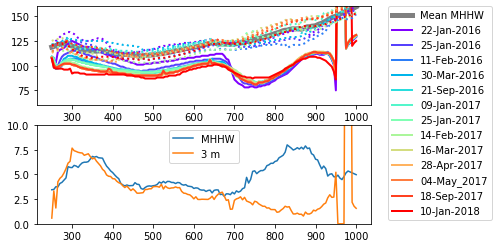

In [28]:
color=plt.cm.rainbow(np.linspace(0,1,nmaps-1))
plt.subplot(211)
plt.plot(pts[7,:,0],mean_MHHW,c='gray',linewidth=5,label="Mean MHHW")
for imap,c in zip(range(nmaps-1),color):
   plt.plot(pts[imap,:,0],pts[imap,:,5],c=c,linewidth=2,label=titles[imap])
for imap,c in zip(range(nmaps-1),color):
   plt.plot(pts[imap,:,0],pts[imap,:,6],':',c=c,linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([60,160])

plt.subplot(212)
plt.plot(pts[imap,:,0],std_MHHW,label='MHHW')
plt.plot(pts[imap,:,0],std_3m,label='3 m')
plt.ylim([0, 10])
plt.legend()

NameError: name 'iy' is not defined

Text(0.5, 1.0, 'y=850.0')

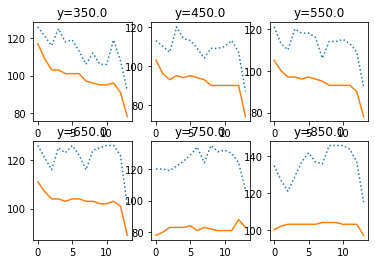

In [56]:
ip=20
plt.subplot(231)
plt.plot(pts[:,ip,6],':')
plt.plot(pts[:,ip,5])
ts = 'y={}'.format(pts[6,ip,0])
plt.title(ts)
ip=40
plt.subplot(232)
plt.plot(pts[:,ip,6],':')
plt.plot(pts[:,ip,5])
ts = 'y={}'.format(pts[6,ip,0])
plt.title(ts)
ip=60
plt.subplot(233)
plt.plot(pts[:,ip,6],':')
plt.plot(pts[:,ip,5])
ts = 'y={}'.format(pts[6,ip,0])
plt.title(ts)
ip=80
plt.subplot(234)
plt.plot(pts[:,ip,6],':')
plt.plot(pts[:,ip,5])
ts = 'y={}'.format(pts[6,ip,0])
plt.title(ts)
ip=100
plt.subplot(235)
plt.plot(pts[:,ip,6],':')
plt.plot(pts[:,ip,5])
ts = 'y={}'.format(pts[6,ip,0])
plt.title(ts)
ip=120
plt.subplot(236)
plt.plot(pts[:,ip,6],':')
plt.plot(pts[:,ip,5])
ts = 'y={}'.format(pts[6,ip,0])
plt.title(ts)

array([9.32880803e+01, 5.08799621e-02])

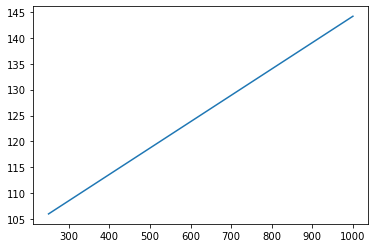

In [117]:
import numpy.polynomial.polynomial as poly

coefs = poly.polyfit(pts[7,:,0], mean_MHHW, 1)
ffit = poly.polyval(pts[7,:,0], coefs)
plt.plot(pts[7,:,0], ffit)
coefs

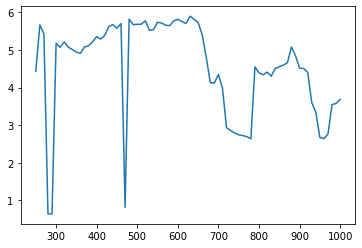

In [65]:
plt.plot(pts[:,0],smap[7,pts[:,1].astype(int),pts[:,0].astype(int)])

In [50]:
np.shape(smap)

(14, 280, 1300)

In [78]:
(7,8)

(7, 8)